# Iris Dataset Variational Quantum Algorithm (VQA)

This subproject explores implementing a fully-functional Variational Quantum Algorithm (VQA) for the task of classification within the Iris dataset.

We use the Iris dataset provided in scikit-learn, and use only two of the species to make this a binary classification task.

In [3]:
from sklearn.datasets import load_iris
import pennylane.numpy as np

loaded = load_iris()
data = loaded.data
target = loaded.target
print(target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


We take only the first two species `setosa` and `versicolor`, given by labels `0` and `1`. We also turn the label for `setosa`, `0` into `-1`.

In [4]:
# Remove species labeled by 2 (keep only species 0 and 1)
mask = target != 2
data_filtered = data[mask]
target_filtered = target[mask]

# change label for setosa to -1
target_filtered[target_filtered == 0] = -1

print("Original dataset shape:", data.shape)
print("Filtered dataset shape:", data_filtered.shape)


Original dataset shape: (150, 4)
Filtered dataset shape: (100, 4)


We maintain an 80/20 training/test split in the data.

Thus we will have 80 training samples, and 20 test samples

In [5]:
split = 0.8

training_X = data_filtered[:int(split*len(data_filtered))]
test_X = data_filtered[int(split*len(data_filtered)):]

training_Y = target_filtered[:int(split*len(target_filtered))]
test_Y = target_filtered[int(split*len(target_filtered)):]

print(training_X.shape)
print(test_X.shape)
print(training_Y.shape)
print(test_Y.shape)

print(np.max(training_X))
print(np.min(training_X))
print(np.max(test_X))
print(np.min(test_X))

print(training_X)
print(training_Y)

(80, 4)
(20, 4)
(80,)
(20,)
7.0
0.1
6.7
1.0
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  

## Encoding

We have 4 features to encode for each sample, so we'll start with a 4-qubit circuit.

In [6]:
import pennylane as qml

In [7]:
dev = qml.device("default.qubit", wires=4)

# borrowed from data-encoder project
def simple_angle_encoding(x, rotator="RX"):
    op = qml.RY if rotator == "RY" else qml.RX
    for i in range(len(x)):
        op(x[i], wires=i)


@qml.qnode(dev)
def circuit(layer_weights, sample):
    simple_angle_encoding(sample, rotator="RY")



    for layer in range(len(layer_weights)):
        for wire in range(len(sample)):
            qml.Rot(*layer_weights[layer], wires=wire)
        # entanglement
        for i in range(len(sample)):
            qml.CNOT(wires=[i, (i+1)%len(sample)])


    return qml.expval(qml.PauliZ(0))

Testing our encoding and layering with a sample:

(<Figure size 1400x500 with 1 Axes>, <Axes: >)

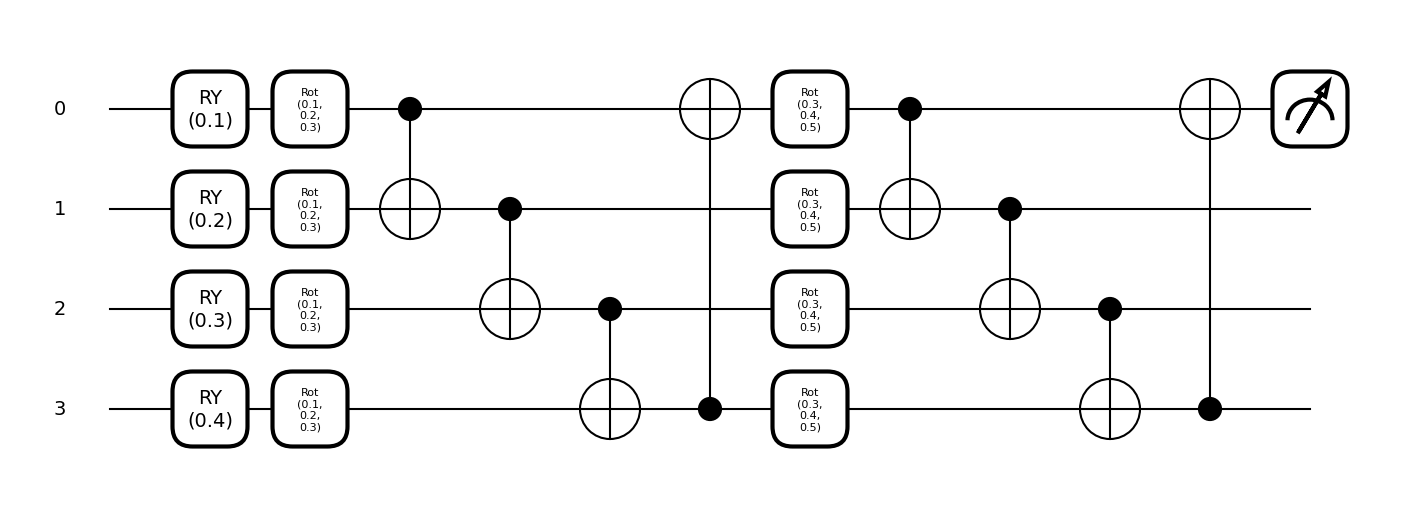

In [8]:
qml.draw_mpl(circuit, decimals=1)([[0.1, 0.2, 0.3], [0.3,0.4,0.5]],[0.1, 0.2, 0.3, 0.4])

Looks good. Let's define our functions:

In [9]:
def predict(layer_weights, bias, sample):
    return circuit(layer_weights, sample) + bias

def square_loss(predictions, labels):
    return np.mean((predictions - labels)**2)

def cost(weights, bias, X, Y):
    predictions = np.array([predict(weights, bias, sample) for sample in X])
    return square_loss(predictions, Y)

def accuracy(weights, bias, X, Y):
    predictions = np.array([predict(weights, bias, sample) for sample in X])
    return np.mean(np.sign(predictions) == Y)

In [10]:
num_layers = 10
weights = np.random.randn(num_layers, 3, requires_grad=True)
bias = np.array(0.0, requires_grad=True)


In [11]:
opt = qml.AdamOptimizer(stepsize=0.5)
batch_size = 5

Here's where we train:

In [12]:
costs = [None] * 100
accs = [None] * 100
for i in range(100):
    batch_index = np.random.randint(0, len(training_X), (batch_size,))
    batch_X = training_X[batch_index]
    batch_Y = training_Y[batch_index]

    weights, bias = opt.step(cost, weights, bias, X=batch_X, Y=batch_Y)

    costs[i] = cost(weights, bias, training_X, training_Y)
    accs[i] = accuracy(weights, bias, training_X, training_Y)

    if i % 10 == 0:
        print(f"Iteration {i}: Cost = {costs[i]}, Accuracy = {accs[i]}")

print(f"Final weights: {weights}")
print(f"Final bias: {bias}")

Iteration 0: Cost = 1.0995386760423007, Accuracy = 0.625
Iteration 10: Cost = 0.45114797042585064, Accuracy = 0.95
Iteration 20: Cost = 0.4239628463195967, Accuracy = 0.725
Iteration 30: Cost = 0.3468048940786326, Accuracy = 1.0
Iteration 40: Cost = 0.23415019627819927, Accuracy = 0.9875
Iteration 50: Cost = 0.09712943247600739, Accuracy = 1.0
Iteration 60: Cost = 0.1580114387794396, Accuracy = 1.0
Iteration 70: Cost = 0.16639281451241272, Accuracy = 1.0
Iteration 80: Cost = 0.05402679508017947, Accuracy = 1.0
Iteration 90: Cost = 0.06843853441926691, Accuracy = 1.0
Final weights: [[ 2.91976905  2.23545932  3.53665458]
 [ 1.79190332  1.07313728  0.29339175]
 [ 2.82843596 -1.54882834  1.05713733]
 [ 1.73751089  2.51554198  1.85198044]
 [-2.77845826 -2.40862128 -0.60569518]
 [ 0.7635674   2.00927664  1.8559661 ]
 [ 3.54981609 -0.4912136  -0.50992089]
 [ 2.40839752  1.27547058  3.43857643]
 [ 4.08429406  0.97597378  1.2983278 ]
 [ 1.04693953 -0.80146284  0.63739473]]
Final bias: 0.0143458

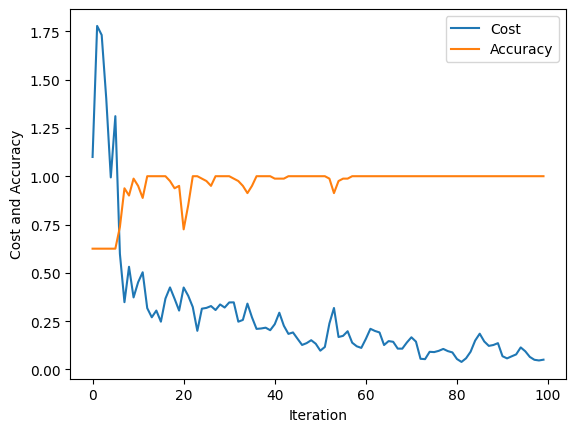

In [15]:
import matplotlib.pyplot as plt

plt.plot(costs)
plt.plot(accs)
plt.xlabel("Iteration")
plt.ylabel("Cost and Accuracy")
plt.legend(["Cost", "Accuracy"])
plt.show()

Now we test for accuracy on the test set:

In [14]:
acc = accuracy(weights, bias, test_X, test_Y)
print(f"Accuracy on test set: {acc}")

Accuracy on test set: 1.0
